In [10]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [11]:
import numpy as np
import pandas as pd

In [12]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [13]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [14]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [15]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [16]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [17]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [18]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [20]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Find last data point
lastdate = session.query(func.max(measurement.date)).scalar()
lastdate = dt.datetime.strptime(lastdate, '%Y-%m-%d')

# Calculate the date 1 year ago from the last data point in the database
one_year_ago = lastdate - dt.timedelta(365)


# Perform a query to retrieve the data and precipitation scores
result = session.query(measurement.date, measurement.prcp).filter(measurement.date>one_year_ago).all()




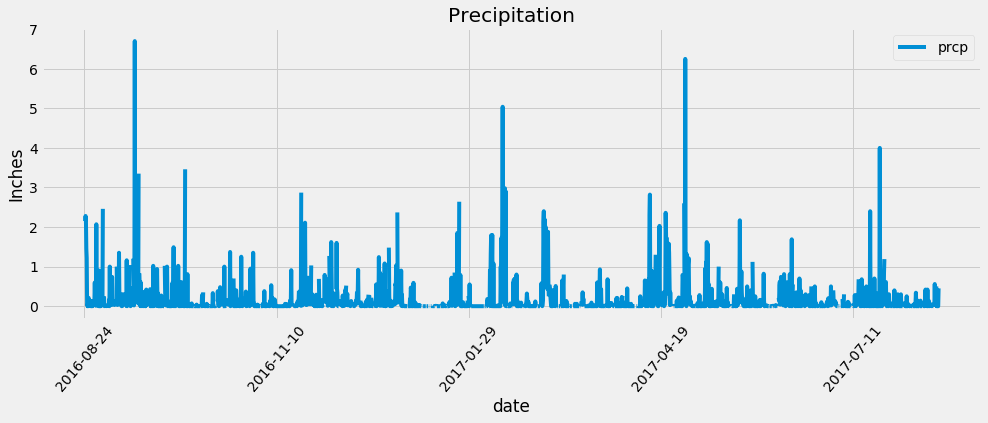

In [23]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(result)
df = df.set_index('date')

# Sort the dataframe by date
df = df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(figsize=(15,5), rot=50)
plt.title("Precipitation")
plt.ylabel("Inches")
plt.savefig("Images/Precipitation_plt.png")
plt.show()


In [24]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()




,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [25]:
# Design a query to show how many stations are available in this dataset?

stations = session.query(station).count()
print(f"There are {stations} stations available in this dataset.")


There are 9 stations available in this dataset.


In [27]:
# What are the most active stations? (i.e. what stations have the most rows)?
most_active_stations = session.query(measurement.station,func.count(measurement.station))\
.group_by(measurement.station)\
.order_by(func.count().desc()).all()


# List the stations and the counts in descending order.
most_active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [52]:
#Which station is the most active (i.e. has the highest number of observations)?

most_active_station = most_active_stations[0][0]

print(f"The most active station is {most_active_station}.")

The most active station is USC00519281.


In [53]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

most_active_station_temps = session.query(func.min(measurement.tobs), func.max(measurement.tobs),func.avg(measurement.tobs)).filter(measurement.station==most_active_station).first()

print(f"At the most active station, {most_active_station}, the lowest temperature, highest temperature, and average temperature was: {most_active_station_temps}.")



At the most active station, USC00519281, the lowest temperature, highest temperature, and average temperature was: (54.0, 85.0, 71.66378066378067).


In [64]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

highest_tobs = session.query(measurement.tobs).filter(measurement.date >= one_year_ago).\
filter(measurement.station == most_active_station).order_by(measurement.date).all()
            
highest_tobs_df = pd.DataFrame(highest_tobs)
highest_tobs_df

                                                      
                                                      

,tobs
0,77.0
1,80.0
2,80.0
3,75.0
4,73.0
...,...
346,77.0
347,77.0
348,76.0
349,76.0


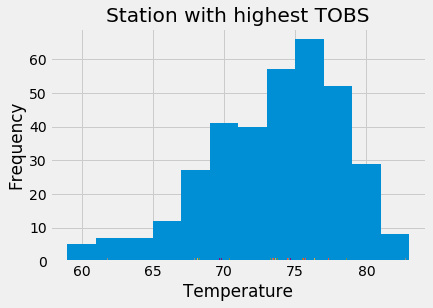

In [66]:
plt.hist(highest_tobs_df["tobs"], bins = 12)
n, bins, patches = plt.hist(highest_tobs_df, bins = 12) 

plt.title("Station with highest TOBS")
plt.xlabel("Temperature")                                             
plt.ylabel("Frequency")  
                                                      
plt.savefig("Images/Station with higest TOBS_hist.png")
plt.show()  

## Bonus Challenge Assignment

In [69]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [75]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

vacation_dates = calc_temps('2017-07-12', '2017-08-21')
vacation_dates

print(f"Low, average, and high temps for my vacation dates last year were {vacation_dates}.")

Low, average, and high temps for my vacation dates last year were [(70.0, 78.71698113207547, 85.0)].
